# Generative Adverserial Networks
In this notebook, we will train a Generative Adverserial Network (GAN) model to generate images similar to the ones in CIFAR-10:https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import tensorflow.keras as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot


## Load the Dataset
The dataset consists of 60,000 32×32 pixel color images of objects belonging to 10 classes, such as frogs, birds, and cats. Let's load and visualize a few sample images from this dataset:

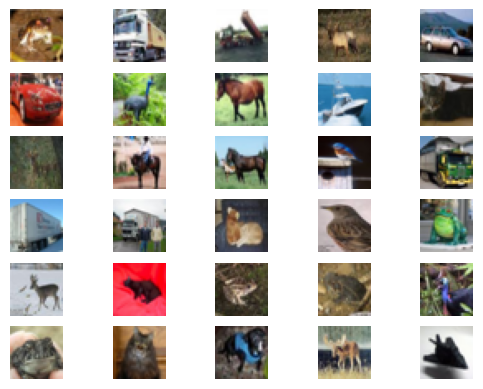

In [2]:
(trainX, trainy), (testX, testy) = load_data()
for i in range(30):
    pyplot.subplot(6, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i])
pyplot.show()

Let's put the logic to load the train X in a function so that we can call it from our main code

In [3]:
def load_CIFAR10_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X


When training the dsicriminator, we will use a combination of real and generated samples. Shuffling the input data helps the perfromance of gradient descent algorithm, to acheive this we will write a function which randomly samples images from the training set. We will use label 0 for fake images and label 1 for real images.

In [4]:
def generate_real_samples(dataset, num_samples):
    rand_indxes = randint(0, dataset.shape[0], num_samples)
    X = dataset[rand_indxes]
    # assign 1 for the label (real images)
    y = ones((num_samples, 1))
    return X, y


## Generate Fake Samples
Below, we implement *generate_fake_samples* function which generates images of random pixel values using the genereator model. We will also implement the *return_random_latent_points* function which generates a random multi-dimensional array to be used as the input to the generator model.



In [5]:

# generate points in latent space as input for the generator
def return_random_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = return_random_latent_points(latent_dim, n_samples)
    # generate an output image using the generative model
    X = generator_model.predict(x_input)
    # we assign a label of 0 for the fake images
    y = zeros((n_samples, 1))
    return X, y


## Define the Discriminator Model

The descriminator model takes a sample image as input and predicts whether the sample is real or fake (binary classification). The discriminator model is a 4-layer convolutional Neural Network. We use a 2×2 stride in some layers to downsample the input image in layers 2,3, and 4. The final layer has a sigmoid activation function to predict if the input sample is real or fake. We use a binary cross entropy loss function since it is a binary classification.
Often time, in training GANs LeakyReLU activation is used instead of ReLU which works better for this scenario as it helps the gradients flow easier through the architecture.

In [6]:
def create_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = K.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [7]:
create_discriminator().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

2022-09-27 16:57:09.204217: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Define the Generator Model
The goal of the generator model is to prdouce fake but believable images of objects siilar to the ones in the training set.The generator model needs an initial random seed to generate an image, we will take a radnom point from the latent space (n-dimensional vector of random guassian numbers) use it as the input (seed) to the generator model. At th end of the training the latent vector space will represent a compressed representation of the space of images in the dataset, CIFAR-10 images. Basically, the generator model willl take this random vector(point in latent space) and transforms it to an 32 x 32 x 3 array.

In the generator, we will upsample the output of some layers using the Conv2DTranspose opertator which is a combination of convolution and upsampling with a stride of (2×2) that will quadruple the area of the input feature maps. Conv2DTranspose will learn the best upsamling for the task.

In [8]:
def create_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


In [9]:
create_generator(100).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

## Define the GAN Model

There is an adverserial relationship between the genrator and the discriminator: when the discriminator distinguishes the fake samples from the real well, the generator is updated more, and when the discriminator is performing poor the generator model is updated less. In order to implement such a amodel,  we will create a new model by appending the discriminator model to the end of the generator. The generator (in fact, the entire GAN model) is fed random points in the latent space as its input and generates sample images that are fed into the discriminator model then, and the gradient of the discriminator is used to update the model weights of the generator.


One way to achieve this is to train the discriminator in a standalone manner uisng a batch of fake and then real samples. Then we freeze the discriminator network by marking all of the layers in the discriminator as not trainable (preventing the discriminator network weights from being updated) and train the generator model using the random vectors from the latent space. But, there is an important trick when training the genertaor, we label the fake images generated by it as real (label 1), as we want the discriminator to think that these fake samples generated by the generator are real. Consequently, if the discriminator is doing a good job, it should predict these inastnces as fake, thus increasing the gradient of loss function which is used to updated the generator netowrks weights, and eventually forcing the generator to generate even more realastic images.

__Note__:  Since discriminator.trainable = False is set after the discriminator is compiled, it will not apply to the discriminator network itdelf. But, it will apply to the combined model and the discriminator layers will be frozen when the combined model is trained, because it is set before the combined model is compiled.

In [14]:
def create_gan(generator_model, discriminator_model):
    # make weights in the discriminator not trainable
    discriminator_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator_model)
    # add the discriminator
    model.add(discriminator_model)
    # compile model
    opt =  K.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


## Train the Model
Before we train the GAN model, we will define a function that will help us to capture the progress of our GAN model across the training epochs.

In [15]:
# evaluate the discriminator performance, save sample generated images, and save the generator model
def eval_GAN_performance(epoch, generator_model, discriminator_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    #  Saves a plot of sample generated images
    examples = (examples + 1) / 2.0
    num_of_images_in_a_row=5
    for i in range(num_of_images_in_a_row * num_of_images_in_a_row):
        pyplot.subplot(num_of_images_in_a_row, num_of_images_in_a_row, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = 'generated_images_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()
    
    # save the generator model to a file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    generator_model.save(filename)


below is the final training code for our GAN model. As you can see, the discriminator model is trained twice per batch, once with real samples and once with fake samples (this helps the model to converge better rather than combining the fake and real samples in a single round of training). 

Also note that we label the fake sample with 1 (real image) when trainig the GAN, can you guess why?

In [19]:
n_epochs=100
n_batch=128
latent_dim = 100
discriminator_model = create_discriminator()
generator_model = create_generator(latent_dim)
gan_model = create_gan(generator_model, discriminator_model)
dataset = load_CIFAR10_samples()

batch_per_epoch = int(dataset.shape[0] / n_batch)

for i in range(n_epochs):
    for j in range(batch_per_epoch):
        # randomly select real samples
        X_real, y_real = generate_real_samples(dataset, int(n_batch / 2))
        # update discriminator model weights using the real samples as input
        discriminator_loss_real, _ = discriminator_model.train_on_batch(X_real, y_real)

        # generate fake samples
        X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, int(n_batch / 2))
        # update discriminator model weights using fake samples
        discriminator_loss_fake, _ = discriminator_model.train_on_batch(X_fake, y_fake)

        # generatoe random points in latent space to be used as input for the generator
        X_gan = return_random_latent_points(latent_dim, n_batch)
        # assign real label to fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        generator_loss = gan_model.train_on_batch(X_gan, y_gan)

        print('epoch%d,  batch %d of %d, discriminator_loss_real =%.3f, discriminator_loss_fake=%.3f generator_loss=%.3f' %(i+1, j+1, batch_per_epoch, discriminator_loss_real,  discriminator_loss_fake, generator_loss))

    # evaluate the model performance once every  5 epochs
    if (i+1) % 5 == 0:
        eval_GAN_performance(i, generator_model, discriminator_model, dataset, latent_dim)


epoch1,  batch 1 of 390, discriminator_loss_real =0.689, discriminator_loss_fake=0.695 generator_loss=0.691
epoch1,  batch 2 of 390, discriminator_loss_real =0.619, discriminator_loss_fake=0.698 generator_loss=0.689
epoch1,  batch 3 of 390, discriminator_loss_real =0.545, discriminator_loss_fake=0.704 generator_loss=0.683
epoch1,  batch 4 of 390, discriminator_loss_real =0.450, discriminator_loss_fake=0.720 generator_loss=0.669
epoch1,  batch 5 of 390, discriminator_loss_real =0.351, discriminator_loss_fake=0.758 generator_loss=0.639
epoch1,  batch 6 of 390, discriminator_loss_real =0.243, discriminator_loss_fake=0.836 generator_loss=0.600
epoch1,  batch 7 of 390, discriminator_loss_real =0.180, discriminator_loss_fake=0.921 generator_loss=0.574
epoch1,  batch 8 of 390, discriminator_loss_real =0.156, discriminator_loss_fake=0.945 generator_loss=0.598
epoch1,  batch 9 of 390, discriminator_loss_real =0.154, discriminator_loss_fake=0.865 generator_loss=0.679
epoch1,  batch 10 of 390, di

UnboundLocalError: local variable 'examples' referenced before assignment